# I. About Statelog (German Credit data)

The chosen dataset for this project represents 1000 individuals who took a credit.

With each observation an outcome is associated (1 for Good meaning the borrower did not default, 2 for Bad meaning the borrower defaulted).

[This dataset is available on UCI Manchine Learning repository](https://archive.ics.uci.edu/ml/datasets/Statlog+(German+Credit+Data))

It has comprehensive information about 1000 borrowers. Nonetheless, it does say anything about the time when the credit was authorized and the time when a creditor defaulted, nor about the interest rate of the issued credit.

This additional information could have been really handy to have a more comprehensive picture.

We are provided with two sets of data :
- A set of data where Ordinal values are presented as categorical
- A set of data with only numeric values (and added features)

The issue with the second dataset is that the meaning of the features are not documented. For this reason, we will focus on the first dataset.

Let's first inspect the data before presenting the goals we will pursue.

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(rc={"figure.figsize": (12, 6)})



/usr/local/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
data = pd.read_csv('all.tsv', sep=' ', header=None, names= ["bank_account_status","duration_month", "credit_history", "purpose", "credit_amount","savings","employed_since","installment_percentage_of_income","personal_status_and_sex","gurantor","residence_since","property","age","other_credits","housing","nb_credit_at_bank","job_qualification","nb_pp_cater_for","telephone?","foreigner?","result"])

n_observations = data.shape[0]
n_features = data.shape[1] - 1
output = data.ix[:,-1]
good_creditors = float(data.ix[:,-1][data.ix[:,-1] == 1].count()) / n_observations

print 'Number of observations: {0}'.format(data.shape[0])
print 'Number of features: {0}'.format(data.shape[1] - 1)
print 'Percentage of good creditors: {0:.2f} % '.format(good_creditors * 100)

data.head()

Number of observations: 1000
Number of features: 20
Percentage of good creditors: 70.00 % 


,bank_account_status,duration_month,credit_history,purpose,credit_amount,savings,employed_since,installment_percentage_of_income,personal_status_and_sex,gurantor,...,property,age,other_credits,housing,nb_credit_at_bank,job_qualification,nb_pp_cater_for,telephone?,foreigner?,result
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,2


Below is the numeric dataset. 4 features have been added. But unfortunatelly, we don't know which ones!

In [3]:
data_numeric = pd.read_csv('numeric.tsv', delim_whitespace=True, header=None)
data_numeric.head()

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,1,6,4,12,5,5,3,4,1,67,...,0,0,1,0,0,1,0,0,1,1
1,2,48,2,60,1,3,2,2,1,22,...,0,0,1,0,0,1,0,0,1,2
2,4,12,4,21,1,4,3,3,1,49,...,0,0,1,0,0,1,0,1,0,1
3,1,42,2,79,1,4,3,4,2,45,...,0,0,0,0,0,0,0,0,1,1
4,1,24,3,49,1,3,3,4,4,53,...,1,0,1,0,0,0,0,0,1,2


# II. Objectives of the study

Now that we imported the data, let's see the different insights and metrics we can extract from this 1000 borrowers.

We have 20 attributes describing the borrowers and an output variable stating if we are talking of a "Good" borrower or borrower who encountered a default.

Our goal is to select the model which "best" separates good and bad borrowers, which is a critical activity for Credit companies.

## How to evaluate best?

In this particular case we want to minimize the false positive.

The reason is that giving a credit to someone who is not paying costs a lot.

The credit company gets the interests in case reimboursements are met.

It **looses the capital** (+ the expected interests) when not reimboursed!

[The page presenting the dataset](https://archive.ics.uci.edu/ml/datasets/Statlog+(German+Credit+Data) states that : *It is worse to class a customer as good when they are bad (5), than it is to class a customer as bad when they are good (1). *

That matches the following hypothesis:
- Interest rate is 10%
- customers who don't meet their payment, do so when they have already reimboursed 50% of the borrowed capital

Which seems reasonable for consumer credit (avg credit is 3271 DM, roughly 1600 dollars 30 years back...)

In [4]:
print "credit average is : {0:.0f} DM".format(data['credit_amount'].mean())

credit average is : 3271 DM


From this statements, we derive a cost function (see below) that will be used to assess the performance of our models.

## Categorical or ordinal features

6 out of 20 features are ordinal.

For instance :
```
Present employment since 
A71 : unemployed 
A72 : ... < 1 year 
A73 : 1 <= ... < 4 years 
A74 : 4 <= ... < 7 years 
A75 : .. >= 7 years```

We will first treat them as categorical to find out the type of model that performs better our classification task. After that, we will try to see if converting those to ordinal helps to be more accurate.

In [5]:
#ax = sns.countplot(y="employed_since", hue="result", data=data, palette="Set3")

# III. Preprocessing

In [6]:
X = data.ix[:,:-1]
y = data['result']

In [7]:
X.columns.tolist()

['bank_account_status',
 'duration_month',
 'credit_history',
 'purpose',
 'credit_amount',
 'savings',
 'employed_since',
 'installment_percentage_of_income',
 'personal_status_and_sex',
 'gurantor',
 'residence_since',
 'property',
 'age',
 'other_credits',
 'housing',
 'nb_credit_at_bank',
 'job_qualification',
 'nb_pp_cater_for',
 'telephone?',
 'foreigner?']

In [8]:
def preprocess(X,convert_numeric=False):
    outX = pd.DataFrame(index=X.index)
    target_cols = ['credit_history','employed_since','gurantor','property','other_credits','job_qualification']
    for col in X.columns:
        if convert_numeric == True and col in target_cols:
            distinct_val = sorted(X[col].unique())
            new_col = X[col].replace(distinct_val,range(0,len(distinct_val)))
        elif X[col].dtype == object:
            values = X[col].value_counts()
            nb_values = len(values)
            if nb_values == 2:
                new_col = X[col].replace([values.index[0],values.index[1]],[0,1])
            else:
                new_col = pd.get_dummies(X[col],prefix=col)
        else:
            new_col = X[col]

        outX = outX.join(new_col)
    return outX
    

In [9]:
X_all = preprocess(X) # with categorical features
X_all_num = preprocess(X,convert_numeric=True) # with ordinal features

## Choosing the best model

In [10]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn import cross_validation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import make_scorer
from sklearn import metrics
import time
from IPython.display import Image
from sklearn.externals.six import StringIO
from sklearn import tree
import pydot
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.grid_search import RandomizedSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler

In [11]:
def cost(y,y_pred):
    confusion_m = confusion_matrix(y,y_pred)
    cost_matrix = np.array([[0,1],[5,0]])
    return np.diag(np.transpose(cost_matrix).dot(confusion_m)).sum()
cost_estimate = make_scorer(cost,greater_is_better=False)

In [12]:
def train_classifier(clf, X_train, y_train):
    print "Training {}...".format(clf.__class__.__name__)
    start = time.time()
    clf.fit(X_train, y_train)
    end = time.time()
    print "Done!\nTraining time (secs): {:.3f}".format(end - start)

In [13]:
def predict_labels(clf, features, target):
    print "Predicting labels using {}...".format(clf.__class__.__name__)
    start = time.time()
    y_pred = clf.predict(features)
    end = time.time()
    print "Done!\nPrediction time (secs): {:.3f}".format(end - start)
    return cost(target.values, y_pred)

In [14]:
def train_predict(clf, X_train, y_train, X_test, y_test):
    print "------------------------------------------"
    print "Training set size: {}".format(len(X_train))
    train_classifier(clf, X_train, y_train)
    print "Cost estimation for training set: {}".format(predict_labels(clf, X_train, y_train))
    print "Cost estimation for test set: {}".format(predict_labels(clf, X_test, y_test))

In [15]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X_all, y, test_size=0.2,random_state=15)

X_train_num, X_test_num, y_train_num, y_test_num = cross_validation.train_test_split(X_all_num, y, test_size=0.2,random_state=15)

In [16]:
from sklearn.grid_search import GridSearchCV
parameters = {'max_depth': range(6,9,1),
             'min_samples_split': range(5,61,5),
             'max_features' : range(15,26,2)}
clf = DecisionTreeClassifier()

tree_model = GridSearchCV(clf,parameters, scoring=cost_estimate,cv=5)
tree_model.fit(X_train, y_train)
print tree_model.best_params_
print tree_model.best_score_

{'max_features': 25, 'min_samples_split': 35, 'max_depth': 6}
-146.82875


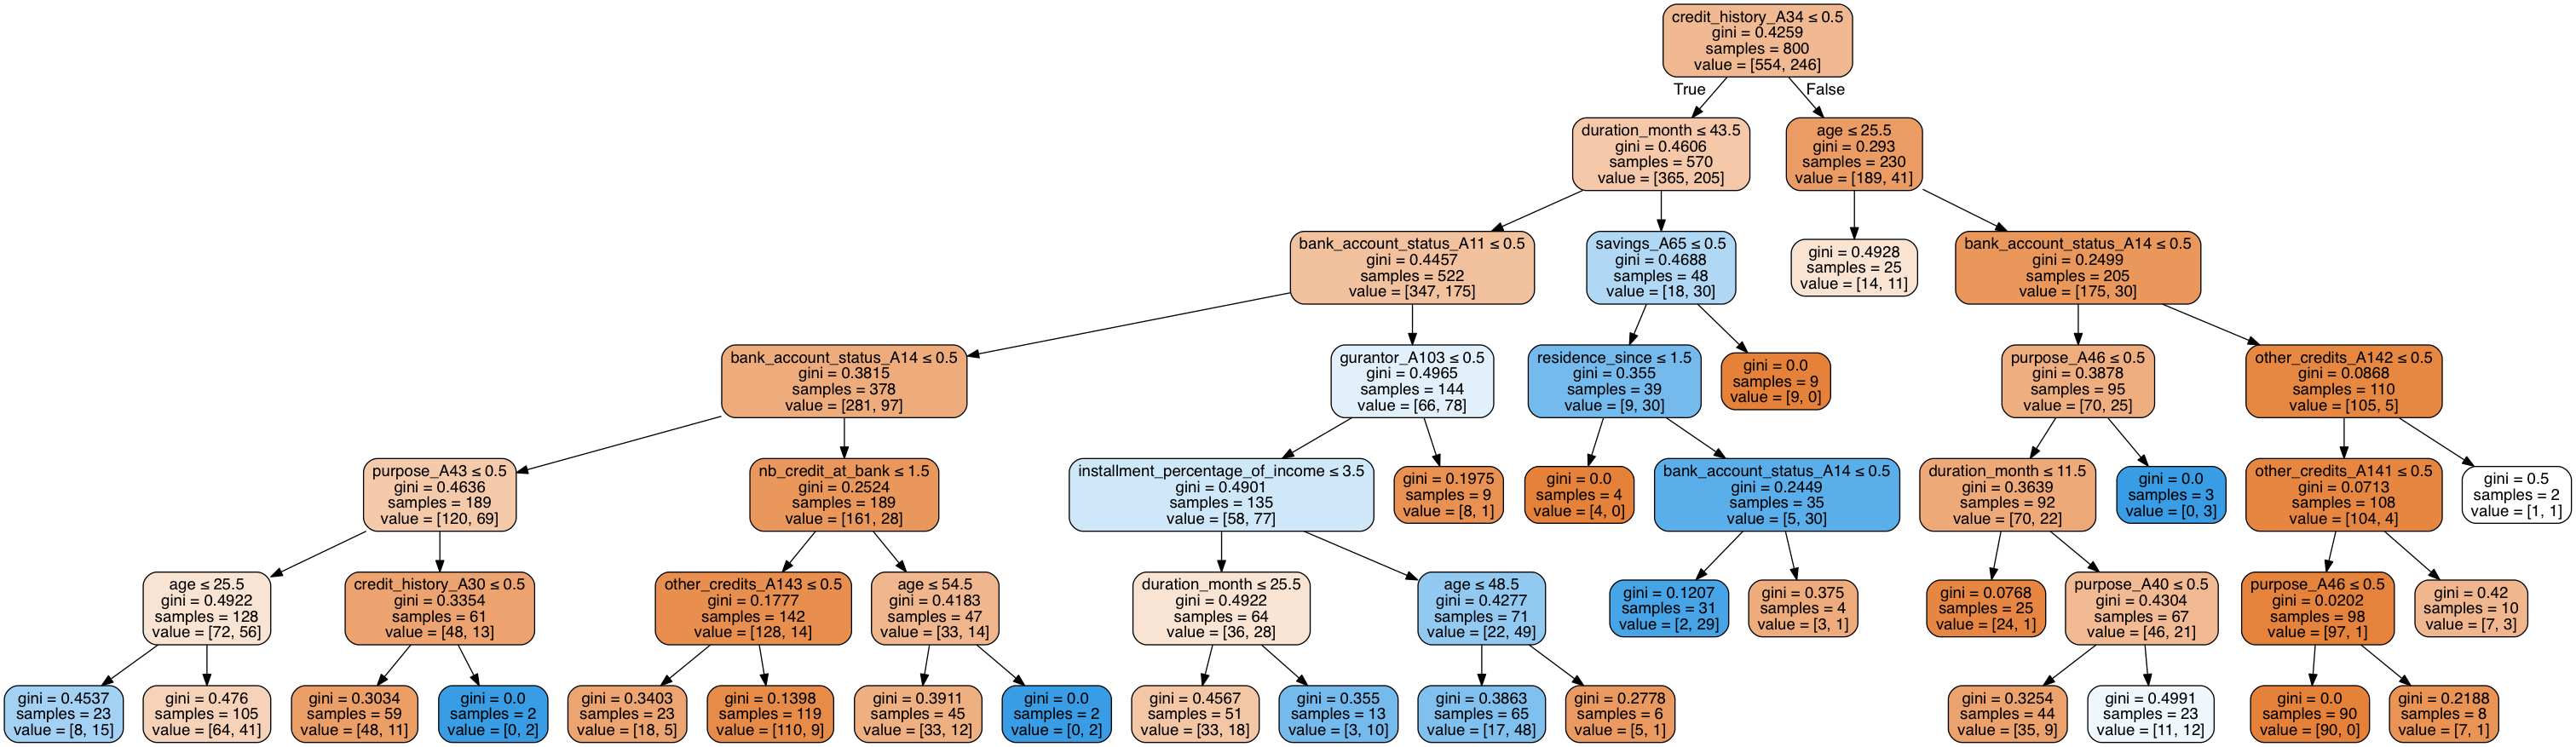

In [17]:
dot_data = StringIO()
tree.export_graphviz(tree_model.best_estimator_, out_file=dot_data,  
                         feature_names=X_all.columns.tolist(),  
                         filled=True, rounded=True,  
                         special_characters=True)
graph = pydot.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())


In [18]:

parameters = {'max_depth': range(6,9,1),
             'min_samples_split': range(5,61,5),
             'max_features' : range(22,26,1)}

rf = RandomForestClassifier(n_estimators=20,n_jobs=-1)
grid_search =  RandomizedSearchCV(rf,parameters, scoring=cost_estimate,cv=5)
grid_search.fit(X_train, y_train)
print grid_search.best_params_
print grid_search.best_score_


{'min_samples_split': 5, 'max_features': 22, 'max_depth': 6}
-153.42125


In [19]:
svm = SVC()
scaler = StandardScaler()
estimators = Pipeline([
    ('scale', scaler), 
#   ('pca', pca),
    ('classifier',svm)
])

parameters = [{
#       'pca__n_components':[10,43,45,50,55,59],
               'classifier__gamma':[0.1,0.007],
               'classifier__C': [20],
              }]
svm_basic = GridSearchCV(estimators,parameters,scoring=cost_estimate,verbose=1,cv=5)
svm_basic.fit(X_train,y_train)
scores = svm_basic.grid_scores_
sorted(scores, key= lambda x: np.mean(x[2]),reverse=True )[:10]

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.7s finished


[mean: -135.56000, std: 14.92113, params: {'classifier__gamma': 0.007, 'classifier__C': 20},
 mean: -233.01500, std: 10.15874, params: {'classifier__gamma': 0.1, 'classifier__C': 20}]

In [20]:


x_tree = ExtraTreesClassifier(n_estimators=50,random_state=13,n_jobs=-1)
svm = SVC()
scaler = StandardScaler()

estimators = Pipeline([
    ('sel',SelectFromModel(x_tree)),
    ('scale', scaler),
    ('classifier',svm)
])

parameters = {'sel__estimator__max_depth':range(5,8,1),
                'sel__estimator__min_samples_split': range(40,61,5),
                'sel__estimator__max_features' : range(20,40,1),
                'sel__estimator__criterion' : ['gini'],
                'sel__estimator__max_leaf_nodes': range(30,40,2),
                'sel__threshold':['median','0.4*median','mean'],
               'classifier__gamma':(0.01,0.009,0.008),
               'classifier__C': (10,15,20,25)}
svm_model = RandomizedSearchCV(estimators,parameters,scoring=cost_estimate,verbose=1,n_iter=50,cv=5)
svm_model.fit(X_train,y_train)
scores = svm_model.grid_scores_
sorted(scores, key= lambda x: np.mean(x[2]),reverse=True )[:10]



[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:   43.2s
[Parallel(n_jobs=1)]: Done 199 tasks       | elapsed:  2.9min


Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:  3.7min finished


[mean: -130.79625, std: 15.03862, params: {'sel__estimator__min_samples_split': 60, 'sel__estimator__max_depth': 7, 'sel__estimator__criterion': 'gini', 'sel__estimator__max_features': 28, 'classifier__C': 20, 'classifier__gamma': 0.009, 'sel__estimator__max_leaf_nodes': 30, 'sel__threshold': '0.4*median'},
 mean: -133.97750, std: 18.47160, params: {'sel__estimator__min_samples_split': 50, 'sel__estimator__max_depth': 5, 'sel__estimator__criterion': 'gini', 'sel__estimator__max_features': 22, 'classifier__C': 25, 'classifier__gamma': 0.01, 'sel__estimator__max_leaf_nodes': 32, 'sel__threshold': '0.4*median'},
 mean: -134.17375, std: 19.21874, params: {'sel__estimator__min_samples_split': 55, 'sel__estimator__max_depth': 6, 'sel__estimator__criterion': 'gini', 'sel__estimator__max_features': 31, 'classifier__C': 25, 'classifier__gamma': 0.01, 'sel__estimator__max_leaf_nodes': 30, 'sel__threshold': '0.4*median'},
 mean: -135.16500, std: 16.06736, params: {'sel__estimator__min_samples_spl

In [21]:
NB = GaussianNB()

x_tree = DecisionTreeClassifier(random_state=13)


estimators = Pipeline([
    ('sel',SelectFromModel(x_tree)),
    ('classifier',NB)
])

parameters = {
                'sel__estimator__max_depth':range(3,10,1),
                'sel__estimator__min_samples_split': range(15,30,2),
                'sel__estimator__max_features' : range(15,25,1),
                'sel__estimator__criterion' : ['gini','entropy'],
                'sel__estimator__max_leaf_nodes': range(20,100,1),
                'sel__threshold':['median','0.5*median','mean','1.1*mean','0.9*mean','1.05*mean','1.2*mean']
              }
nb_model = RandomizedSearchCV(estimators,parameters,scoring=cost_estimate,verbose=1,n_jobs=-1,n_iter=200,cv=5)
nb_model.fit(X_train,y_train)
scores = nb_model.grid_scores_
sorted(scores, key= lambda x: np.mean(x[2]),reverse=True )[:10]

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 744 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    9.8s finished


[mean: -116.02500, std: 13.62351, params: {'sel__estimator__min_samples_split': 29, 'sel__estimator__max_depth': 6, 'sel__estimator__criterion': 'entropy', 'sel__estimator__max_features': 19, 'sel__estimator__max_leaf_nodes': 52, 'sel__threshold': 'mean'},
 mean: -116.06500, std: 18.68689, params: {'sel__estimator__min_samples_split': 27, 'sel__estimator__max_depth': 7, 'sel__estimator__criterion': 'entropy', 'sel__estimator__max_features': 19, 'sel__estimator__max_leaf_nodes': 48, 'sel__threshold': '1.1*mean'},
 mean: -122.17125, std: 8.65794, params: {'sel__estimator__min_samples_split': 15, 'sel__estimator__max_depth': 3, 'sel__estimator__criterion': 'entropy', 'sel__estimator__max_features': 16, 'sel__estimator__max_leaf_nodes': 88, 'sel__threshold': 'median'},
 mean: -122.17125, std: 8.65794, params: {'sel__estimator__min_samples_split': 21, 'sel__estimator__max_depth': 3, 'sel__estimator__criterion': 'gini', 'sel__estimator__max_features': 18, 'sel__estimator__max_leaf_nodes': 41

In [22]:
from sklearn.ensemble import GradientBoostingClassifier
parameters = {
              'max_depth':[2,3,4],
                'min_samples_split':[2,8,20],
                'min_samples_leaf': [26,28,30,32,34],
                'learning_rate':[0.1,0.5,0.01]
             }

GB =  GradientBoostingClassifier()
gb_model = RandomizedSearchCV(GB,parameters, scoring=cost_estimate,n_iter=30,cv=5)
gb_model.fit(X_train, y_train)
print gb_model.best_params_
print gb_model.best_score_
scores = gb_model.grid_scores_

{'min_samples_split': 2, 'learning_rate': 0.5, 'max_depth': 3, 'min_samples_leaf': 32}
-127.22625


In [23]:
sorted(scores, key= lambda x: np.mean(x[2]),reverse=True )[:10]

[mean: -127.22625, std: 13.90539, params: {'min_samples_split': 2, 'learning_rate': 0.5, 'max_depth': 3, 'min_samples_leaf': 32},
 mean: -134.41250, std: 11.74053, params: {'min_samples_split': 2, 'learning_rate': 0.5, 'max_depth': 4, 'min_samples_leaf': 28},
 mean: -137.80750, std: 17.75838, params: {'min_samples_split': 8, 'learning_rate': 0.1, 'max_depth': 4, 'min_samples_leaf': 28},
 mean: -137.79500, std: 18.28004, params: {'min_samples_split': 20, 'learning_rate': 0.5, 'max_depth': 2, 'min_samples_leaf': 34},
 mean: -138.83750, std: 15.87955, params: {'min_samples_split': 8, 'learning_rate': 0.5, 'max_depth': 3, 'min_samples_leaf': 30},
 mean: -139.78125, std: 13.22724, params: {'min_samples_split': 2, 'learning_rate': 0.5, 'max_depth': 2, 'min_samples_leaf': 28},
 mean: -140.42000, std: 13.09351, params: {'min_samples_split': 2, 'learning_rate': 0.5, 'max_depth': 4, 'min_samples_leaf': 34},
 mean: -140.42000, std: 13.09351, params: {'min_samples_split': 20, 'learning_rate': 0.5,

In [24]:
NB_alone = GaussianNB()
sizes = range(200,801,200)

for i,v in enumerate(sizes):
    train_predict(NB_alone,X_train[:v],y_train[:v],X_test,y_test)
    
for i,v in enumerate(sizes):
    train_predict(tree_model,X_train[:v],y_train[:v],X_test,y_test)


------------------------------------------
Training set size: 200
Training GaussianNB...
Done!
Training time (secs): 0.002
Predicting labels using GaussianNB...
Done!
Prediction time (secs): 0.002
Cost estimation for training set: 112
Predicting labels using GaussianNB...
Done!
Prediction time (secs): 0.001
Cost estimation for test set: 138
------------------------------------------
Training set size: 400
Training GaussianNB...
Done!
Training time (secs): 0.001
Predicting labels using GaussianNB...
Done!
Prediction time (secs): 0.001
Cost estimation for training set: 259
Predicting labels using GaussianNB...
Done!
Prediction time (secs): 0.000
Cost estimation for test set: 134
------------------------------------------
Training set size: 600
Training GaussianNB...
Done!
Training time (secs): 0.002
Predicting labels using GaussianNB...
Done!
Prediction time (secs): 0.001
Cost estimation for training set: 413
Predicting labels using GaussianNB...
Done!
Prediction time (secs): 0.001
Cost 

In [25]:
GB_predictions = gb_model.predict(X_test)
svm_predictions = svm_basic.predict(X_test)
svm_predictions_2 = svm_model.predict(X_test)
NB_predictions = nb_model.predict(X_test) 

print "Gradient Boosting"
print cost(y_test,GB_predictions)
print precision_score(y_test,GB_predictions)
print confusion_matrix(y_test,GB_predictions)
print "SVM with Standard Scaler"
print cost(y_test,svm_predictions)
print precision_score(y_test,svm_predictions)
print confusion_matrix(y_test,svm_predictions)
print "SVM 2 "
print cost(y_test,svm_predictions_2)
print precision_score(y_test,svm_predictions_2)
print confusion_matrix(y_test,svm_predictions_2)
print "Naive Bayes 2"
print cost(y_test,NB_predictions)
print confusion_matrix(y_test,NB_predictions)

Gradient Boosting
177
0.8
[[124  22]
 [ 31  23]]
SVM with Standard Scaler
161
0.816993464052
[[125  21]
 [ 28  26]]
SVM 2 
162
0.815789473684
[[124  22]
 [ 28  26]]
Naive Bayes 2
150
[[126  20]
 [ 26  28]]


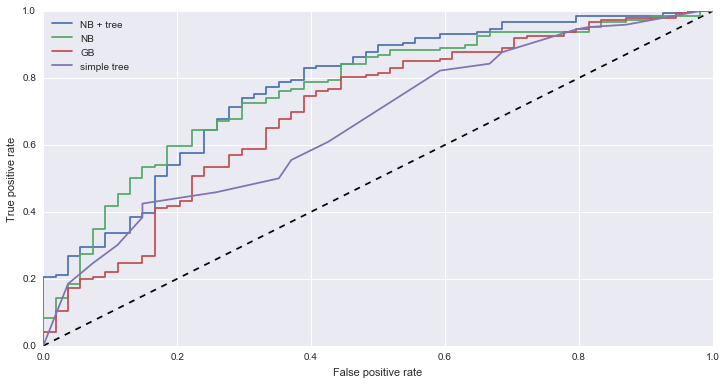

In [26]:
fpr_alone, tpr_alone, thresholds_alone = metrics.roc_curve(y_test, NB_alone.predict_proba(X_test)[:,0],pos_label=1)
fpr, tpr, thresholds = metrics.roc_curve(y_test, nb_model.predict_proba(X_test)[:,0],pos_label=1)
fpr_gb, tpr_gb,t_gb =  metrics.roc_curve(y_test,gb_model.predict_proba(X_test)[:,0],pos_label=1)
fpr_tree, tpr_tree,t_tree =  metrics.roc_curve(y_test,tree_model.predict_proba(X_test)[:,0],pos_label=1)


plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr,tpr,label='NB + tree')
plt.plot(fpr_alone,tpr_alone,label='NB')
plt.plot(fpr_gb,tpr_gb,label='GB')
plt.plot(fpr_tree,tpr_tree,label='simple tree')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc='best');

# Changing the 0.5 probabilistic threshold

As shown below we manage to lower the cost by being a lot more conservative than the model and allowing the credit only when the model is very confident about its prediction.

In [27]:
def chooseThreshold(model,new_threshold):
    prediction = []
    probas = model.predict_proba(X_test)
    for proba in probas:
        if proba[0] > new_threshold:
            prediction.append(1)
        else:
            prediction.append(2)
    return prediction
    
    

[[67 79]
 [ 9 45]]
132


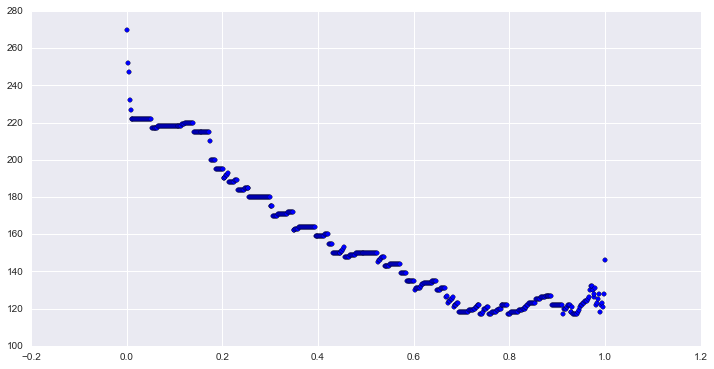

In [28]:
thresholds = np.linspace(0,1,500)

for t in thresholds:
    plt.scatter(t,cost(y_test,chooseThreshold(nb_model,t)))

print confusion_matrix(y_test,chooseThreshold(nb_model,0.96))
print cost(y_test,chooseThreshold(nb_model,0.97))

## Ordinal Values turned to numeric attributes

In [29]:
NB = GaussianNB()

x_tree = DecisionTreeClassifier(random_state=13)


estimators = Pipeline([
    ('sel',SelectFromModel(x_tree)),
    ('classifier',NB)
])

parameters = {
                'sel__estimator__max_depth':range(3,10,1),
                'sel__estimator__min_samples_split': range(15,30,2),
                'sel__estimator__max_features' : range(15,25,1),
                'sel__estimator__criterion' : ['gini','entropy'],
                'sel__estimator__max_leaf_nodes': range(20,100,1),
                'sel__threshold':['median','0.5*median','mean','1.1*mean','0.9*mean','1.05*mean','1.2*mean']
              }
nb_model_num = RandomizedSearchCV(estimators,parameters,scoring=cost_estimate,verbose=1,n_jobs=-1,n_iter=200,cv=5)
nb_model_num.fit(X_train_num,y_train_num)
scores = nb_model_num.grid_scores_
sorted(scores, key= lambda x: np.mean(x[2]),reverse=True )[:10]

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done 248 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    8.7s finished


[mean: -104.80750, std: 6.30555, params: {'sel__estimator__min_samples_split': 23, 'sel__estimator__max_depth': 7, 'sel__estimator__criterion': 'gini', 'sel__estimator__max_features': 16, 'sel__estimator__max_leaf_nodes': 31, 'sel__threshold': 'median'},
 mean: -104.80750, std: 6.30555, params: {'sel__estimator__min_samples_split': 29, 'sel__estimator__max_depth': 3, 'sel__estimator__criterion': 'entropy', 'sel__estimator__max_features': 15, 'sel__estimator__max_leaf_nodes': 96, 'sel__threshold': '0.5*median'},
 mean: -104.80750, std: 6.30555, params: {'sel__estimator__min_samples_split': 27, 'sel__estimator__max_depth': 5, 'sel__estimator__criterion': 'entropy', 'sel__estimator__max_features': 16, 'sel__estimator__max_leaf_nodes': 35, 'sel__threshold': '0.5*median'},
 mean: -104.80750, std: 6.30555, params: {'sel__estimator__min_samples_split': 25, 'sel__estimator__max_depth': 5, 'sel__estimator__criterion': 'entropy', 'sel__estimator__max_features': 24, 'sel__estimator__max_leaf_node

In [30]:
NB_predictions = nb_model_num.predict(X_test_num) 

print "Naive Bayes 2"
print precision_score(y_test_num,NB_predictions)
print confusion_matrix(y_test_num,NB_predictions)
print cost(y_test,NB_predictions)

Naive Bayes 2
0.859504132231
[[104  42]
 [ 17  37]]
127


In [31]:
def chooseThreshold(model,new_threshold):
    prediction = []
    probas = model.predict_proba(X_test_num)
    for proba in probas:
        if proba[0] > new_threshold:
            prediction.append(1)
        else:
            prediction.append(2)
    return prediction
    
    

[[68 78]
 [ 8 46]]
116


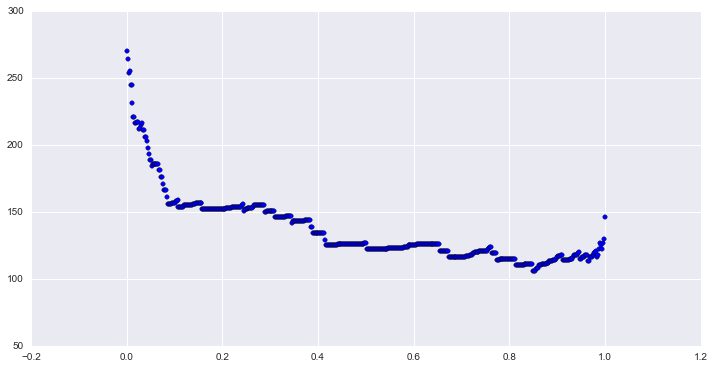

In [32]:
thresholds = np.linspace(0,1,500)

for t in thresholds:
    plt.scatter(t,cost(y_test_num,chooseThreshold(nb_model_num,t)))

print confusion_matrix(y_test,chooseThreshold(nb_model_num,0.96))
print cost(y_test,chooseThreshold(nb_model_num,0.97))

Converting categorical into ordinal values in this present case did not yield improvements.